In [1]:
if(!require("pacman")) install.packages("pacman")
pacman::p_load(arrow, janitor, rlang,cardx, gtsummary, gt, ggupset,ggvenn, ggsci,RColorBrewer, patchwork, psych, binom,effectsize, rcompanion,rstatix,confintr, tidyverse)

Loading required package: pacman


# Data

In [2]:
# Chief complaint data
data_cc <- read_parquet('../MIMICED/chiefcomp_clustered.parquet') |> 
  select(stay_id, cluster)

# ED data
ed_data <- read_parquet("../MIMICED/ed_join_cc.parquet") |> 
  # Ill only keep some columns for this analysis
  left_join(
    data_cc,
    by = "stay_id"
  ) |>
  # add a grouping column for the tables
  mutate(
    combined_group = paste0(nyu, res, acuity_out)
  ) |> 
  arrow_table()

# Analysis

In [3]:
print("N of visits before dropping NA acuity, age or race")
print(nrow(ed_data |> collect()))

[1] "N of visits before dropping NA acuity, age or race"
[1] 424707


In [4]:
print("N of visits before dropping NA acuity")
ed_data <- ed_data |> 
  filter(!is.na(acuity) & !is.na(age) & !is.na(race)) |> 
  compute()
vis_tot <- nrow(ed_data |> collect())
print(vis_tot)

[1] "N of visits before dropping NA acuity"
[1] 417723


In [5]:
print("N of distinct patients")
ed_data |> 
  select(subject_id) |>
  collect() |>
  distinct(subject_id) |>
  count() |> 
  print()

[1] "N of distinct patients"
# A tibble: 1 × 1
       n
   <int>
1 201106


Keep only the first visist by each patient

In [6]:
ed_data <- ed_data |> 
  collect() |> 
  arrange(intime) |> 
  group_by(subject_id) |> 
  slice_head(n = 1) |>
  ungroup() 

# Table 1
Create table 1 and table S1.   

Create table 1 data

In [7]:
table_1_data<- ed_data |> 
  collect() |> 
  select(
    age,
    gender,
    race,
    Diagnosis = nyu,
    Resources = res,
    'Triage Acuity' = acuity_out
  ) |> 
  mutate(
    All = 1,
    race = case_when(
      str_detect(race, "WHITE") ~ "White",
      str_detect(race, "BLACK") ~ "Black",
      str_detect(race, "HISPANIC") ~ "Hispanic/Lation",
      str_detect(race, "ASIAN") ~ "Asian",
      T ~ "Other"
    ),
    race = as_factor(race),
    gender = case_when(
      gender == "M" ~ "Male",
      gender == "F" ~ "Female"
    ),
    gender = as_factor(gender)
  ) |> 
  drop_na() |>
  pivot_longer(
    cols = c(All, Diagnosis,Resources,'Triage Acuity'),
    names_to = "outcome",
    values_to = "value"
  ) |> 
  filter(
    value == 1
  ) 

In [8]:
table_1 <- table_1_data |> 
  mutate(
    age_mean = age,
    age_median = age
  ) |>
  select(-value, -age) |>
  tbl_summary(
    by = outcome,
    label = list(
      age_mean ~ "Age (Years, mean)",
      age_median ~ "(Years, median)",
      gender ~ "Gender (%)",
      race ~ "Self-reported Race (%)"
    ),
    statistic = list(
      age_mean ~ "{mean}",
      age_median ~ "{median} ({min}-{max})",
      all_categorical() ~ "{p}%"
    ),
    sort =  all_categorical() ~ "frequency",
    digits = list(everything() ~ c(0, 0))
  ) |> 
  bold_labels() |> 
  add_ci(
    include = c(age_mean, all_categorical()),
    method = list(
      age_mean ~ "t.test",
      all_categorical() ~ "agresti.coull"
      ),
    statistic = list(
      age_mean ~ "{conf.low}, {conf.high}", 
      all_categorical() ~ "{conf.low}%, {conf.high}%"
    ),
    pattern = "{stat} [{ci}]",
    conf.level = 0.95
  ) |>
  modify_spanning_header(
    c(stat_2, stat_3, stat_4) ~ "**Potentially Avoidable ED Visits Algorithm**"
  ) |>
  modify_footnote_header(
    footnote = "Confidence interval (CI) for categorical variables is computed using Agresti-Coull interval.",
    columns = all_stat_cols(),
    replace = TRUE
  ) |>
  modify_footnote_body(
    footnote = "For clarity, self-reported races have been collapsed. Full details can be found in the supplementary material.",
    columns = "label",
    rows = variable == "race" & row_type == "label",
    replace = TRUE
  ) 


# Display the table
table_1 |> 
  as_tibble() |> 
  print(n=30)

# save the tables
table_1 |> 
  as_gt() |> 
  gt::gtsave(filename = "table_1.docx") 


# A tibble: 11 × 5
   `**Characteristic**`       **All**  \nN = 201,106 [*…¹ **Diagnosis**  \nN =…²
   <chr>                      <chr>                       <chr>                 
 1 __Gender (%)__             NA                          NA                    
 2 Female                     54% [53%, 54%]              60% [60%, 60%]        
 3 Male                       46% [46%, 47%]              40% [40%, 40%]        
 4 __Self-reported Race (%)__ NA                          NA                    
 5 White                      62% [62%, 62%]              55% [55%, 56%]        
 6 Black                      16% [16%, 16%]              20% [20%, 21%]        
 7 Other                      10% [9.7%, 10%]             10% [9.5%, 10%]       
 8 Hispanic/Lation            6% [6.4%, 6.6%]             8% [8.2%, 8.6%]       
 9 Asian                      6% [5.5%, 5.7%]             6% [6.0%, 6.4%]       
10 __Age (Years, mean)__      49 [49, 49]                 45 [45, 46]           
11 __(Yea

In [9]:
# Create table S1
table_S1 <- table_1_data |> 
  select(
    race,
    outcome
  ) |> 
  collect() |> 
  drop_na() |>
  tbl_summary(
    by = outcome,
    label = list(
      race ~ "Race"
    ),
    statistic = list(
      all_categorical() ~ "{n} ({p}%)"
    ),
    sort =  all_categorical() ~ "frequency"
  )

# Save table S1
table_S1 |> 
  as_gt() |> 
  gt::gtsave(filename = "table_S1.docx") 

# Number of visits identified

In [10]:
num_vs <- ed_data |>
  filter(combined_group != "000") |>
  nrow() 
num_vs |> print()

[1] 100568


In [11]:
print(paste(
  "Percentage of visits identified:",
  round(num_vs/nrow(ed_data |> collect())*100, 1)
))

[1] "Percentage of visits identified: 50"


In [12]:
num_vs <- ed_data |>
  filter(combined_group != "000") |>
  group_by(combined_group) |>
  count(sort = T) |>
  print()

# A tibble: 7 × 2
# Groups:   combined_group [7]
  combined_group     n
  <chr>          <int>
1 100            44119
2 010            23427
3 110            17306
4 001             4690
5 011             4278
6 101             3578
7 111             3170


# Agreement (Kappa)

In [13]:
# Get data
fig1_data <- ed_data |> 
  select(
    nyu,
    res,
    acuity_out
  ) |> 
  collect() 

In [14]:
k1 <- cohen.kappa(x = cbind(fig1_data$nyu, fig1_data$acuity_out))
k2 <- cohen.kappa(x = cbind(fig1_data$nyu, fig1_data$res))
k3 <- cohen.kappa(x = cbind(fig1_data$acuity_out, fig1_data$res))

kappa_df_ci <- tibble(
  Var1 = c("Diagnosis", "Diagnosis", "Triage Acuity"),
  Var2 = c("Triage Acuity", "Resources", "Resources"),
  kappa = c(k1$kappa, k2$kappa, k3$kappa),
  ci_lower = c(k1$confid[1], k2$confid[1], k3$confid[1]),
  ci_upper = c(k1$confid[2], k2$confid[2], k3$confid[2])
)

kappa_df_ci |> 
  print()

# A tibble: 3 × 5
  Var1          Var2           kappa ci_lower ci_upper
  <chr>         <chr>          <dbl>    <dbl>    <dbl>
1 Diagnosis     Triage Acuity 0.0388   0.0356   0.0356
2 Diagnosis     Resources     0.0990   0.0946   0.0946
3 Triage Acuity Resources     0.131    0.126    0.126 


# Figure 1
Create the upset plot for the interaction between sets

I use the JAMA pallette for now, but can be changed

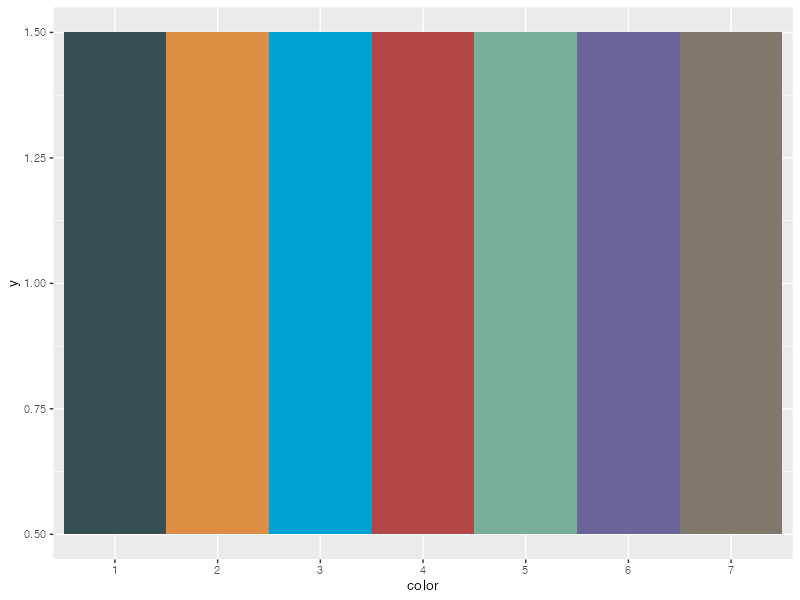

In [15]:
jama_palette <- ggsci::pal_jama()(7)
data.frame(
  color = factor(seq_along(jama_palette)),
  hex = jama_palette
) |> 
  ggplot(aes(x = color, y = 1, fill = hex)) +
  geom_tile() +
  scale_fill_identity() 

Data for figure 1

## Figure 1A

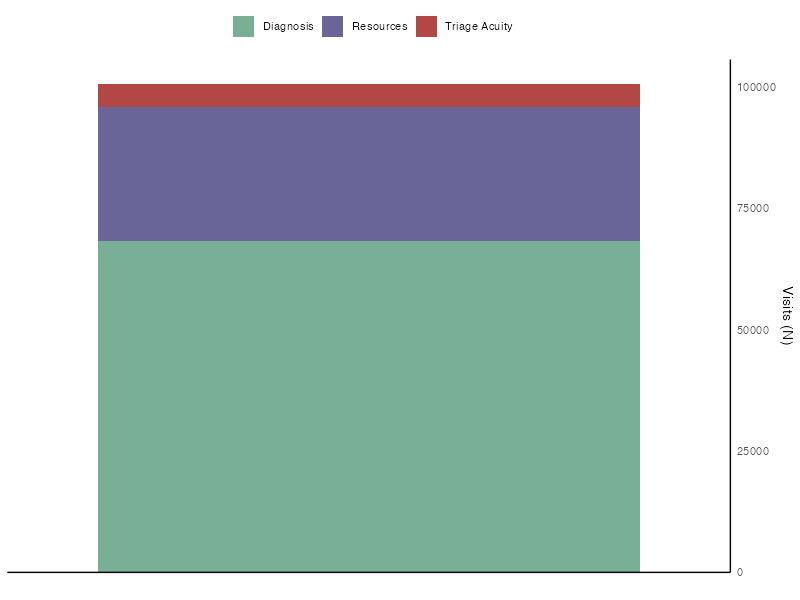

In [16]:
# Compute counts
fig_1a_counts <- tibble(
  "Diagnosis" = fig1_data |> filter(nyu == 1) |> nrow(),
  "Resources" = fig1_data |> filter(res == 1, nyu == 0) |> nrow(),
  "Triage Acuity" = fig1_data |> filter(acuity_out == 1,res == 0, nyu == 0) |> nrow()
) |> 
pivot_longer(everything(), names_to = "category", values_to = "count") |>
mutate(
  category = factor(category, levels = c("Triage Acuity", "Resources",  "Diagnosis"))
) 

figure_1a <- ggplot(fig_1a_counts, aes(x = "Total", y = count, fill = category)) +
geom_bar(stat = "identity") +
theme_minimal()+
  labs(
    x="",
    y = "Visits (N)",
    fill = ""
  ) +
scale_y_continuous(
  expand = expansion(mult = c(0, 0.05)),
  position = "right"
)+
# Pick colours to match the upset plot
scale_fill_manual(values = jama_palette[c(4, 6, 5)])+
guides(fill = guide_legend(reverse = TRUE)) +
theme(
  panel.grid = element_blank(),
  legend.position="top",
  axis.line = element_line(color = "black"),
  axis.text.x = element_blank()
)

figure_1a

In [17]:
# Compute counts
# fig_1a_counts <- tibble(
#     nyu = fig1_data |> filter(nyu == 1) |> nrow(),
#     res_addtional = fig1_data |> filter(res == 1, nyu == 0) |> nrow(),
#     acuity_additional = fig1_data |> filter(acuity_out == 1,res == 0, nyu == 0) |> nrow()
# ) 
# fig_1a_trib <- tribble(
#   ~bar,       ~segment, ~count,
#   "Diagnosis", "Diagnosis",      fig_1a_counts$nyu,
#   "Diagnosis+Resources", "Diagnosis", fig_1a_counts$nyu,
#   "Diagnosis+Resources", "Resources", fig_1a_counts$res_addtional,
#   "Diagnosis+Resources+\n Triage-Acuity", "Diagnosis", fig_1a_counts$nyu,
#   "Diagnosis+Resources+\n Triage-Acuity", "Resources", fig_1a_counts$res_addtional,
#   "Diagnosis+Resources+\n Triage-Acuity", "Triage-Acuity", fig_1a_counts$acuity_additional
# ) |> 
#   mutate(
#     bar = factor(bar, levels = c("Diagnosis", "Diagnosis+Resources",  "Diagnosis+Resources+\n Triage-Acuity")),
#     segment = factor(segment, levels = c( "Triage-Acuity", "Resources", "Diagnosis")),
#   )

# figure_1a <- fig_1a_trib |> 
#   ggplot(aes(x = bar, y = count, fill = segment)) +
#   geom_bar(stat = "identity")  +
#   labs(
#     x="",
#     fill = ""
#   ) +
#   theme_minimal()+
#   scale_y_continuous(expand = expansion(mult = c(0, 0.05)))+
#   # Pick colours to match the upset plot
#   scale_fill_manual(values = jama_palette[c(4, 6, 5)])+
#   guides(fill = guide_legend(reverse = TRUE)) +
#   theme(
#     panel.grid = element_blank(),
#     legend.position="top",
#     axis.line = element_line(color = "black"),
#     axis.text.x = element_blank(),
#     axis.title.y = element_blank()
#   )

# print(figure_1a)

## Figure 1B   

UpSet plot

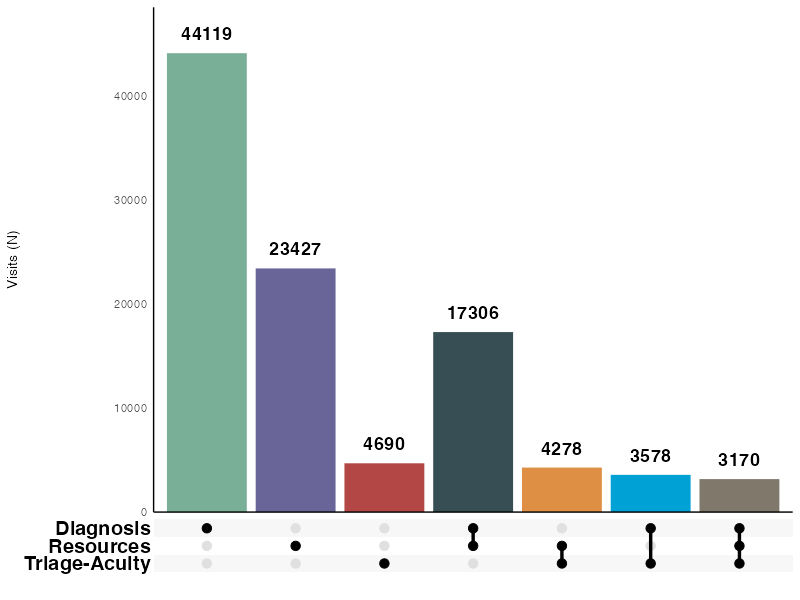

In [34]:
set_levels <- c("Diagnosis", "Resources", "Triage-Acuity")  
# Turn columns into lists
 data_sets <-  fig1_data |>
    mutate(sets = pmap(list(nyu, res, acuity_out), function(nyu, res, acuity_out) {
      members <- c(
        if (nyu == 1) "Diagnosis",
        if (res == 1) "Resources",
        if (acuity_out == 1) "Triage-Acuity"
      )
    members
  }))

# Calculate counts for each combination
set_summary <- data_sets |>
  filter(lengths(sets) > 0) |>
  mutate(sets_label = sapply(sets, \(x) paste(sort(x), collapse = " + "))) |>
  count(sets_label, sort = TRUE)

# Define custom order: single sets first, then intersections by descending count
single_order <- c("Diagnosis", "Resources", "Triage-Acuity")
intersections_order <- set_summary |>
  filter(!sets_label %in% single_order) |>
  arrange(desc(n)) |>
  pull(sets_label)
custom_order <- c(single_order, intersections_order)

# Assign a display order to each combination
order_map <- tibble(
  sets_label = custom_order,
  display_order = seq_along(custom_order)
)

# Create plot data with custom ordering variable
plot_data <- data_sets |> 
  filter(lengths(sets) > 0) |>
  mutate(
    sets_label = sapply(sets, \(x) paste(sort(x), collapse = " + "))
  ) |>
  left_join(order_map, by = "sets_label") |>
  mutate(
    sets_label = factor(sets_label, levels = custom_order)
  )

# Create plot
figure_1b <- plot_data |>
  ggplot(aes(x = sets, fill = sets_label, order = display_order)) +
  geom_bar() +
  scale_x_upset(order_by = "degree") + 
  geom_text(
    stat="count", 
    aes(label=after_stat(count)), 
    vjust=-1, 
    size = 5,
    colour = "black",
    fontface = "bold"
  )+
  scale_y_continuous(expand = expansion(mult = c(0, 0.1)))+
  labs(x = "Set Intersections", y = "Count")+
  theme_minimal()+
  theme(
      legend.position = "none",
      panel.grid=element_blank(),
      axis.line = element_line(color = "black")
    )+
  theme_combmatrix(
    combmatrix.label.text = element_text(
      size =15, 
      colour = "black",
      face = "bold"
    )
  )+ # Set the font size for matrix
  labs(
    x="",
    y="Visits (N)"
  )+
  scale_fill_manual(
    values = jama_palette[c(5,6,4,1,2,3,7)] 
  ) 

print(figure_1b)

## Join

In [ ]:
layout <- "
AAAA
BB##
"
Figure_1 <- figure_1b+figure_1a+
  plot_layout(
    # design = layout,
    # widths = c(2, 1),  # left vs right column widths
    # heights = c(3, 3)  # height ratio of p1a vs p1b
  )+ 
  plot_annotation(
    tag_levels = "A"
  )&
  theme(
    plot.tag = element_text(
      color = "black", 
      size = rel(1.5), 
      face = "bold"
    ),
    axis.text = element_text(
      size=rel(1.5), 
      colour = "black", 
      face = "bold"
    ),
    axis.title = element_text(
        size = rel(1.5), 
        colour = "black",
        face = "bold"
    ),
    legend.text = element_text(
      size = rel(1.2), 
      colour = "black",
      face = "bold"
    )
  )

ggsave("figure_1.png", plot = Figure_1, device = "png", width = 15, height = 10, units = "in", dpi = 600)
ggsave("figure_1.svg", plot = Figure_1, device = "svg", width = 8, height = 6, units = "in")
Figure_1

# Table 2

In [21]:
# data for table
table_2_data <- ed_data |> 
  select(
    age,
    gender,
    pain,
    acuity,
    disposition,
    length_of_stay,
    revisit_72hrs,
    prior_visits_1yr,
    nyu,
    res,
    acuity_out,
    combined_group
  ) |> 
  collect() |> 
  mutate(
    revisit_72hrs = case_when(
      revisit_72hrs == "NO" ~ 0,
      T ~ 1
    ),
    admitted = case_when(
      disposition == "ADMITTED" ~ 1,
      T ~ 0
    ),
    home = case_when(
      disposition == "HOME" ~ 1,
      T ~ 0
    ),
    male = case_when(
      gender == "M" ~ 1,
      T ~ 0
    ),
    female = case_when(
      gender == "F" ~ 1,
      T ~ 0
    ),
    acuity = as.integer(acuity),
    pain = as.integer(pain),
    total_alg = nyu + res + acuity_out,
    only_one_algorithm = if_else(total_alg == 1, TRUE, FALSE)
  ) 
total_n <- nrow(ed_data |> collect())

In [54]:
# Functions for table
prop_fn <- function(x, n) {
  ci <- binom::binom.confint(sum(x) , n, method = "agresti-coull")
  proportion = ci$mean*100
  lower_95 = ci$lower*100
  upper_95 = ci$upper*100
  sprintf("%.1f [%.1f-%.1f]", proportion, lower_95, upper_95)
}

summarise_mean <- function(x) {
   # Perform t-test to obtain CI
  t_result <- t.test(x, conf.level = 0.95, na.rm = TRUE)
  
  # Create a named list of results
  mean = round(t_result$estimate,1)
  lower_95_CI = round(t_result$conf.int[1],1)
  upper_95_CI = round(t_result$conf.int[2], 1)
  sprintf("%.1f [%.1f-%.1f]", mean, lower_95_CI, upper_95_CI)
}

summarise_median <- function(x) {
  q1 <- quantile(x, 0.25, names = FALSE, na.rm = TRUE)
  med <- median(x, na.rm = TRUE)
  q3 <- quantile(x, 0.75, names = FALSE, na.rm = TRUE)
  sprintf("%d [%d-%d]", med, q1, q3)
}

my_anova <- function(data, variable, group) {
  # Extract variable names as strings
  var_name <- as_name(enquo(variable))
  group_name <- as_name(enquo(group))
  formula <- reformulate(group_name, response = var_name)
  model <- aov(formula, data = data)
  x <- effectsize::eta_squared(model, alternative = "two.sided", verbose = FALSE)
  sprintf("%.2f [%.2f-%.2f]", x$Eta2[1], x$CI_low[1], x$CI_high[1])
}

my_chi <- function(data, variable, by) {
      # Create contingency table
  tab <- table(data[[variable]], data[[by]])
  chi_res <- chisq.test(tab)
  cv <- ci_cramersv(chi_res)
  sprintf("%.2f [%.2f-%.2f]", cv$estimate, cv$interval[[1]], cv$interval[[2]])
}

compute_cohen_w_ci <- function(var){
  # 1. Tabulate observed proportions
  observed_tbl <- table(var)
  observed_n <- sum(observed_tbl)
  observed_prop <- observed_tbl / observed_n
  
  # 2. Expected proportions (uniform if not provided)
  k <- length(observed_tbl)
  expected_prop <- rep(1 / k, k)
    
  # 3. Compute Cohen's w
  cohen_w <- sqrt(sum((observed_prop - expected_prop)^2 / expected_prop))
  
  # 4. Bootstrapping CI
  all_levels <- names(observed_tbl)
  set.seed(123)  # for reproducibility
  bootstrap_w <- replicate(1000, {
    v1_sample <- sample(var, length(var), replace = TRUE)
    obs_tbl <- table(factor(v1_sample, levels = all_levels))
    obs_prop <- obs_tbl / sum(obs_tbl)
    sqrt(sum((obs_prop - expected_prop)^2 / expected_prop))
  })
  
  alpha <- 1 - 0.95
  ci_lower <- quantile(bootstrap_w, alpha / 2)
  ci_upper <- quantile(bootstrap_w, 1 - alpha / 2)
  
  # 5. Return formatted string
  sprintf("%.2f [%.2f-%.2f]", cohen_w, ci_lower, ci_upper)
}


# Create tables 
table_2a_data <- table_2_data 

props <- table_2a_data |> 
  group_by(combined_group) |>
  mutate(
    props = (n() / nrow(table_2_data))*100
  ) |> 
  ungroup()

# Calculate averages
avgs <- table_2a_data |> 
  group_by(combined_group) |>
  summarise(
    Count = n(),
    Proportion = prop_fn(Count, nrow(ed_data |> collect())),
    Age = summarise_mean(age), 
    Female = prop_fn(female, n()),
    Pain = summarise_median(pain),
    Acuity = summarise_median(acuity),
    `Length of stay` = summarise_mean(length_of_stay),
    Home = prop_fn(home, n()),
    Admitted = prop_fn(admitted, n()),
    .groups = "drop"
  ) 

# Append eta row manually
eta_row <- tibble(
  combined_group = "Effect size",
  Count = NA,
  Proportion = compute_cohen_w_ci(table_2a_data$combined_group),
  Age = my_anova(table_2a_data, age, combined_group),
  Female = my_chi(table_2a_data, "female", "combined_group"),
  Pain = my_anova(table_2a_data, pain, combined_group),
  Acuity = my_anova(table_2a_data, acuity, combined_group),
  `Length of stay` = my_anova(table_2a_data, length_of_stay, combined_group),
  Home = my_chi(table_2a_data, "home", "combined_group"),
  Admitted = my_chi(table_2a_data, "admitted", "combined_group")
)

# Join the tables
table2a <- bind_rows(avgs, eta_row) |> 
  mutate(across(
    everything(), 
    ~as.character(.)
    )
  ) |>
  ## Transpose the table
  pivot_longer(
    cols        = -combined_group,
    names_to    = "variable",
    values_to   = "value"
  ) |> 
  filter(
    combined_group != "000"
  ) |> 
  mutate(
    combined_group = factor(
      combined_group, 
      levels = c("100", "010", "001", "110", "011","101", "111", "Effect size")
    )
  ) |> 
  pivot_wider(
    names_from  = combined_group,
    values_from = value
  ) |> 
  rename(
    Diagnosis = "100",
    Resource = "010",
    Acuity = "001",
    `Diagnosis+Resources` = "110",
    `Resources+Acuity` = "011",
    `Diagnosis+Acuity` = "101",
    All = "111"
  ) |> 
  select(
    variable,
    Diagnosis,
    Resource,
    Acuity,
    `Diagnosis+Resources`,
     `Resources+Acuity`,
     `Diagnosis+Acuity`, 
     All,
     `Effect size`
  )

table2a |> 
  print()

table2a |> 
  gt() |> 
  gtsave(filename = "table_2a.docx")



# A tibble: 9 × 9
  variable       Diagnosis           Resource            Acuity              `Diagnosis+Resources` `Resources+Acuity`  `Diagnosis+Acuity`  All                 `Effect size`   
  <chr>          <chr>               <chr>               <chr>               <chr>                 <chr>               <chr>               <chr>               <chr>           
1 Count          44119               23427               4690                17306                 4278                3578                3170                NA              
2 Proportion     21.9 [21.8-22.1]    11.6 [11.5-11.8]    2.3 [2.3-2.4]       8.6 [8.5-8.7]         2.1 [2.1-2.2]       1.8 [1.7-1.8]       1.6 [1.5-1.6]       1.25 [1.25-1.26]
3 Age            47.0 [46.9-47.2]    42.2 [42.0-42.5]    38.1 [37.6-38.5]    44.5 [44.2-44.8]      35.3 [34.9-35.8]    37.8 [37.3-38.4]    37.3 [36.7-37.9]    0.08 [0.07-0.08]
4 Female         60.9 [60.4-61.4]    50.1 [49.4-50.7]    50.3 [48.9-51.8]    59.5 [58.7-60.2]      49.

## 2B

In [55]:
table_2b <- table_2_data |>
  summarise(
    Count = n(),
    Proportion = prop_fn(Count, nrow(ed_data |> collect())),
    Age = summarise_mean(age), 
    Male = prop_fn(male, n()),
    Female = prop_fn(female, n()),
    Pain = summarise_median(pain),
    Acuity = summarise_median(acuity),
    `Length of stay` = summarise_mean(length_of_stay),
    Home = prop_fn(home, n()),
    Admitted = prop_fn(admitted, n()),
    .groups = "drop"
  ) |> 
  ungroup() |> 
   mutate(across(
    everything(), 
    ~as.character(.)
    )
  ) |>
  ## Transpose the table
  pivot_longer(
    cols        = everything(),
    names_to    = "variable",
    values_to   = "All"
  ) 

table_2b |> 
  print()

table_2b |> 
  gt() |> 
  gtsave(filename = "table_2b.docx")
  

# A tibble: 10 × 2
   variable       All                
   <chr>          <chr>              
 1 Count          201106             
 2 Proportion     100.0 [100.0-100.0]
 3 Age            49.2 [49.1-49.3]   
 4 Male           46.4 [46.2-46.6]   
 5 Female         53.6 [53.4-53.8]   
 6 Pain           4 [0-7]            
 7 Acuity         3 [2-3]            
 8 Length of stay 391.5 [390.0-393.0]
 9 Home           60.4 [60.2-60.6]   
10 Admitted       34.2 [34.0-34.4]   


# Table 3

In [24]:
table3_data <- ed_data |> 
  select(
    icd_chapter,
    primary_code,
    cluster,
    nyu,
    res,
    acuity_out,
    combined_group
  ) |> 
  collect() |> 
  mutate(
      cluster = case_when(
      cluster==0 ~"Lower back pain",
      cluster==1 ~"Influenza like illness",
      cluster==2 ~"Vehicle collision + Altered mental status",
      cluster==3 ~"Chest pain + dyspnea",
      cluster==4 ~"Shortness breath",
      cluster==5~"Abdomen pain",
      cluster==6~"Leg + knee pain",
      cluster==7~"Wound evaluation",
      cluster==8~"Alcohol intoxication",
      cluster==9~"Nausea vomiting",
      cluster==10 ~"Suicidal ideation",
      cluster==11 ~"Fall transfer",
      T~as.character(cluster)),
      total_alg = nyu + res + acuity_out,
      only_one_algorithm = if_else(total_alg == 1, TRUE, FALSE)
    ) |> 
  select(
    -nyu,
    -res,
    -acuity_out
  ) 

In [25]:
# Helper function: get top 3 per group and format as "value (n)"
get_top_n_formatted <- function(df, var, n = 3) {
  df |>
    group_by(combined_group, !!sym(var)) |>
    summarise(n = n(), .groups = "drop") |>
    group_by(combined_group) |>
    mutate(group_total = sum(n),
          pct = n / group_total * 100,
          label = paste0(!!sym(var), " (", round(pct, 1), "%)")) |>
    arrange(combined_group, desc(pct)) |>
    group_by(combined_group) |>
    slice_max(order_by = pct, n = n) |>
    group_by(combined_group) |>
    mutate(row = row_number()) |>
    select(combined_group, row, label) |>
    pivot_wider(names_from = combined_group, values_from = label) |>
    arrange(row) |>
    select(-row)
}

# Get top 3 ICD codes per group
tbl_icd <- get_top_n_formatted(
  table3_data |>  
    filter(only_one_algorithm), 
  var = "icd_chapter", 
  n = 3
) |> 
  mutate(
    rank = c("1st", "2nd", "3rd")
  ) |> 
  select(
    Rank = rank,
    Diagnosis = `100`,
    Resources = `010`,
    `Triage Acuity` = `001`
  ) 

tbl_cluster <- get_top_n_formatted(
  table3_data|>  
    filter(only_one_algorithm),
  var = "cluster", 
  n = 3
) |> 
  mutate(
    rank = c("1st", "2nd", "3rd")
  ) |> 
  select(
    Rank = rank,
    Diagnosis = `100`,
    Resources = `010`,
    `Triage Acuity` = `001`
  ) 

table_3a <- bind_rows( tbl_cluster, tbl_icd) |> 
  mutate(Spacer = "") |> 
  select(Rank,Spacer, everything()) 

table_3a |> 
  print()
table_3a|> 
  gt() |> 
  tab_row_group(label = "Common Diagnoses (Rank, %)", rows = 1:3) |> 
  tab_row_group(label = "Common Complaints (Rank, %)", rows = 4:6) |> 
  gtsave(filename = "table_3a.docx")


# A tibble: 6 × 5
  Rank  Spacer Diagnosis                               Resources `Triage Acuity`
  <chr> <chr>  <chr>                                   <chr>     <chr>          
1 1st   ""     Abdomen pain (19.1%)                    Wound ev… Wound evaluati…
2 2nd   ""     Lower back pain (12.4%)                 Chest pa… Leg + knee pai…
3 3rd   ""     Vehicle collision + Altered mental sta… Vehicle … Lower back pai…
4 1st   ""     Ill-defined conditions (44.6%)          Injury a… Injury and poi…
5 2nd   ""     Diseases of the musculoskeletal system… Ill-defi… Diseases of th…
6 3rd   ""     Diseases of the skin and subcutaneous … Mental d… Factors influe…


In [26]:
ed_data |> 
  select(icd_chapter, disposition, nyu, res) |>
  collect() |>
  pivot_longer(
    cols = c(nyu, res),
    names_to = "group",
    values_to = "value"
  ) |>
  filter(value==1, disposition =="ADMITTED") |> 
  group_by(icd_chapter, group) |>
  count() |>
  arrange(desc(n), icd_chapter) |> 
  print(n=30)

# A tibble: 18 × 3
# Groups:   icd_chapter, group [18]
   icd_chapter                                                    group     n
   <chr>                                                          <chr> <int>
 1 Ill-defined conditions                                         nyu    2759
 2 Diseases of the digestive system                               nyu    1311
 3 Diseases of the circulatory system                             nyu    1302
 4 Diseases of the skin and subcutaneous tissue                   nyu    1196
 5 Diseases of the genitourinary system                           nyu     950
 6 Diseases of the musculoskeletal system                         nyu     796
 7 Infectious and parasitic diseases                              nyu     593
 8 Diseases of the respiratory system                             nyu     379
 9 Diseases of the nervous system                                 nyu     210
10 Endocrine, nutritional and metabolic diseases                  nyu     163
11 Pregna

## 3B

In [27]:
all_diag_f <- function(col_in){
  ed_data |> 
    collect() |> 
    mutate(
      cluster = case_when(
      cluster==0 ~"Lower back pain",
      cluster==1 ~"Influenza like illness",
      cluster==2 ~"Vehicle collision + Altered mental status",
      cluster==3 ~"Chest pain + dyspnea",
      cluster==4 ~"Shortness breath:",
      cluster==5~"Abdomen pain",
      cluster==6~"Leg + knee pain",
      cluster==7~"Wound evaluation",
      cluster==8~"Alcohol intoxication",
      cluster==9~"Nausea vomiting",
      cluster==10 ~"Suicidal ideation",
      cluster==11 ~"Fall transfer"
      )
    ) |> 
    select(
      col = {{col_in}}
    ) |> 
    count(col, name = "n") |>
    mutate(percentage = n / sum(n) * 100) |>
    arrange(desc(n)) |>
    slice_head(n = 3) |>
    mutate(summary = sprintf("%s (%.1f%%)", col, percentage)) |>
    select(summary)
}


  tbl_icd_all <- all_diag_f(icd_chapter)
  tbl_cluster_all <- all_diag_f(cluster)

  table_3b <- bind_rows(tbl_icd_all, tbl_cluster_all) 

table_3b|> 
  print()
table_3b|> 
  gt() |> 
  gtsave(filename = "table_3b.docx")

# A tibble: 6 × 1
  summary                                          
  <chr>                                            
1 Ill-defined conditions (23.1%)                   
2 Injury and poisoning (21.2%)                     
3 Diseases of the circulatory system (7.9%)        
4 Wound evaluation (21.0%)                         
5 Vehicle collision + Altered mental status (12.1%)
6 Abdomen pain (12.1%)                             


# Save
Save for prediction analysis

In [28]:
write_parquet(ed_data |> collect(), "ed_single.parquet")